In [ ]:

!pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 8.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
hbdf_mitbih_train = pd.read_csv("/content/drive/MyDrive/Wayanad/mitbih_train.csv", header=None)
hbdf_mitbih_test = pd.read_csv("/content/drive/MyDrive/Wayanad/mitbih_test.csv", header=None)
hbdf_mitbih_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
!pip install EMD-signal


In [ ]:
print("Labels Info (Train):")
print(hbdf_mitbih_train[187].value_counts(), "\n")

print("Labels Info (Test):")
print(hbdf_mitbih_test[187].value_counts())

Labels Info (Train):
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64 

Labels Info (Test):
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

# Train data
# Getting the data and their corresponding class labels
x_train = np.array(hbdf_mitbih_train.iloc[:, :187])
y_train = hbdf_mitbih_train[187].values.astype(int)

#Upsampling to counter class imbalance
hb_smote = SMOTE(sampling_strategy={1: 30000, 2: 20000, 3: 20000, 4: 10000}, random_state=42)
x_train, y_train = hb_smote.fit_resample(x_train, y_train)

In [ ]:
from collections import Counter

label_count = Counter(y_train)
print(f"Class wise samples after SMOTE:\n{label_count}")

Class wise samples after SMOTE:
Counter({0: 72471, 4: 6431, 2: 5788, 1: 2223, 3: 641})


In [ ]:
# Test data
# Getting the data and their corresponding class labels
x_test = np.array(hbdf_mitbih_test.iloc[:, :187])
y_test = hbdf_mitbih_test[187].values.astype(float)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, cwt, ricker, stft
from sklearn.decomposition import PCA

In [ ]:
# Simulating a sample ECG signal
np.random.seed(0)  # for reproducibility
t = np.linspace(0, 1, 186)  # 186 points, similar to the data structure mentioned
simulated_ecg = chirp(t, f0=6, f1=1, t1=1, method='linear') + np.random.normal(0, 0.1, 186)

# Performing Continuous Wavelet Transform (CWT)
widths = np.arange(1, 31)
cwt_result = cwt(simulated_ecg, ricker, widths)

# Performing Short Time Fourier Transform (STFT)
f, t_stft, Zxx = stft(simulated_ecg)

/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 186, using nperseg = 186
  warnings.warn('nperseg = {0:d} is greater than input length '


In [ ]:
cwt_result.shape

(30, 186)

In [ ]:
Zxx.shape

(94, 3)

In [ ]:
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 187, using nperseg = 187
  warnings.warn('nperseg = {0:d} is greater than input length '


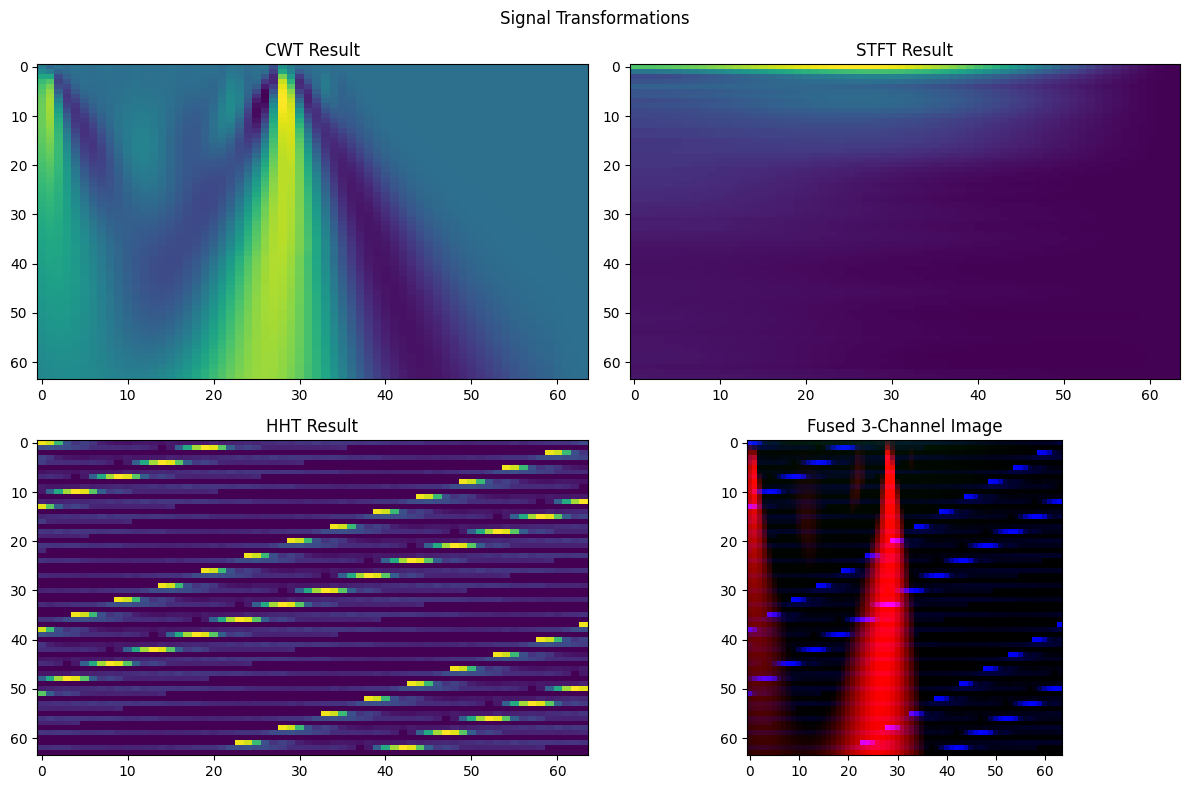

In [ ]:
import numpy as np
from scipy.signal import cwt, ricker, stft
from scipy.ndimage import zoom
from PyEMD import EMD
import matplotlib.pyplot as plt

def extract_features_and_fuse_single_example(signal, target_shape=(64, 64)):
    def apply_hht(signal):
        emd = EMD()
        IMFs = emd(signal)
        return np.sum(IMFs, axis=0)

    # CWT
    widths = np.arange(1, 31)
    cwt_result = cwt(signal, ricker, widths)

    # STFT
    _, _, Zxx = stft(signal)
    stft_magnitude = np.abs(Zxx)

    # HHT
    hht_result = apply_hht(signal)

    # Resize the results to target_shape
    cwt_resized = zoom(cwt_result, [target_shape[0]/cwt_result.shape[0], target_shape[1]/cwt_result.shape[1]])
    stft_resized = zoom(stft_magnitude, [target_shape[0]/stft_magnitude.shape[0], target_shape[1]/stft_magnitude.shape[1]])
    hht_resized = np.resize(hht_result, target_shape)

    if cwt_resized.shape == stft_resized.shape == hht_resized.shape:
        fused_image = np.stack([cwt_resized, stft_resized, hht_resized], axis=-1)

        # Plot each transformation and the fused image
        plt.figure(figsize=(12, 8))

        # CWT
        plt.subplot(2, 2, 1)
        plt.imshow(cwt_resized, aspect='auto')
        plt.title("CWT Result")

        # STFT
        plt.subplot(2, 2, 2)
        plt.imshow(stft_resized, aspect='auto')
        plt.title("STFT Result")

        # HHT
        plt.subplot(2, 2, 3)
        plt.imshow(hht_resized, aspect='auto')
        plt.title("HHT Result")

        # Fused Image
        plt.subplot(2, 2, 4)
        plt.imshow(fused_image)
        plt.title("Fused 3-Channel Image")

        plt.suptitle("Signal Transformations")
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("Resizing did not result in matching shapes for all channels.")

    return fused_image

# Example usage
# signal is a single 1D array from your dataset, e.g., x_train[0]
fused_image = extract_features_and_fuse_single_example(x_train[0])


In [ ]:
import numpy as np
from scipy.signal import cwt, ricker, stft
from scipy.ndimage import zoom
from PyEMD import EMD

def extract_features_and_fuse(x_train, target_shape=(64, 64)):
    """
    Extract features using CWT, STFT, and HHT and fuse into a 3-channel image.

    :param x_train: NumPy array where each row is a signal (ECG)
    :param target_shape: Target shape for resizing (width, height)
    :return: Numpy array of fused images
    """

    def apply_hht(signal):
        """Apply Hilbert-Huang Transform (HHT) on a signal."""
        emd = EMD()
        IMFs = emd(signal)
        return np.sum(IMFs, axis=0)  # Sum of IMFs for simplicity

    # Container for the fused images
    fused_images = []

    for signal in tqdm(x_train):
        # CWT
        widths = np.arange(1, 31)
        cwt_result = cwt(signal, ricker, widths)

        # STFT
        _, _, Zxx = stft(signal)
        stft_magnitude = np.abs(Zxx)

        # HHT
        hht_result = apply_hht(signal)

        # Resize the results to 2D target_shape
        cwt_resized = zoom(cwt_result, [target_shape[0]/cwt_result.shape[0], target_shape[1]/cwt_result.shape[1]])
        stft_resized = zoom(stft_magnitude, [target_shape[0]/stft_magnitude.shape[0], target_shape[1]/stft_magnitude.shape[1]])
        hht_resized = np.resize(hht_result, target_shape)  # Directly resize to 2D target_shape

        # Ensure all have the same shape
        if cwt_resized.shape == stft_resized.shape == hht_resized.shape:
            # Stack to create a 3-channel image
            fused_image = np.stack([cwt_resized, stft_resized, hht_resized], axis=-1)
            fused_images.append(fused_image)
        else:
            raise ValueError("Resizing did not result in matching shapes for all channels.")

    return np.array(fused_images)

# Example usage
# x_train is your NumPy array of shape (8000, 186)
# fused_images = extract_features_and_fuse(x_train)


In [ ]:
x_train_fused_images = extract_features_and_fuse(x_train)


100%|██████████| 87554/87554 [44:54<00:00, 32.49it/s]


In [ ]:
x_test_fused_images = extract_features_and_fuse(x_test)

100%|██████████| 21892/21892 [10:49<00:00, 33.69it/s]


In [ ]:
x_train_fused_images.shape

(87554, 64, 64, 3)

In [ ]:
x_test_fused_images.shape

(21892, 64, 64, 3)

In [ ]:
y_train.shape

(87554,)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Assuming x_train, y_train, x_test, y_test are already defined NumPy arrays

# Convert data to PyTorch tensors and normalize
x_train_tensor = torch.tensor(x_train_fused_images, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # Permute to match channel-first format
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_test_tensor = torch.tensor(x_test_fused_images, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the AlexNet model (modifying the last layer to output 5 classes)
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 5)  # Assuming 5 classes

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 10  # Number of training epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Epoch 1/10, Loss: 0.5201, Accuracy: 85.21%
Epoch 2/10, Loss: 0.3093, Accuracy: 91.99%
Epoch 3/10, Loss: 0.2416, Accuracy: 93.57%
Epoch 4/10, Loss: 0.2039, Accuracy: 94.54%
Epoch 5/10, Loss: 0.1790, Accuracy: 95.22%
Epoch 6/10, Loss: 0.1603, Accuracy: 95.61%
Epoch 7/10, Loss: 0.1475, Accuracy: 96.02%
Epoch 8/10, Loss: 0.1368, Accuracy: 96.17%
Epoch 9/10, Loss: 0.1280, Accuracy: 96.43%
Epoch 10/10, Loss: 0.1207, Accuracy: 96.63%
Test Accuracy: 96.09%


In [ ]:
# Define the AlexNet model (modifying the last layer to output 5 classes)
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 5)  # Assuming 5 classes

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset

# Assuming x_train, y_train, x_test, y_test are defined

# ... [previous code for data preparation and model setup]

# Metrics storage
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 15
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)

    # Testing loop
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * test_correct / test_total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

# Plotting
plt.figure(figsize=(12, 5))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
model_choice = 'efficientnet'  # Change to 'resnet18' for ResNet-18

# Load the pre-trained model
if model_choice == 'efficientnet':
    model = models.efficientnet_v2_s(pretrained=True)
    # Adjust the first convolutional layer and the final fully connected layer
    model.features[0][0] = nn.Conv2d(3, model.features[0][0].out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)  # Assuming 5 classes
elif model_choice == 'resnet18':
    model = models.resnet18(pretrained=True)
    # Adjust the first convolutional layer and the final fully connected layer
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 5)  # Assuming 5 classes

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset

# Assuming x_train, y_train, x_test, y_test are defined

# ... [previous code for data preparation and model setup]

# Metrics storage
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 3
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)

    # Testing loop
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * test_correct / test_total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

# Plotting
plt.figure(figsize=(12, 5))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


100%|██████████| 1369/1369 [05:46<00:00,  3.95it/s]


Epoch 1/3, Train Loss: 0.1267, Train Acc: 96.49%, Test Loss: 0.0923, Test Acc: 97.43%


100%|██████████| 1369/1369 [05:45<00:00,  3.96it/s]


Epoch 2/3, Train Loss: 0.0670, Train Acc: 98.02%, Test Loss: 0.0903, Test Acc: 97.39%


 10%|▉         | 135/1369 [00:34<05:14,  3.93it/s]


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())


In [ ]:
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']))


              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98     18118
     Class 1       0.94      0.52      0.67       556
     Class 2       0.85      0.92      0.88      1448
     Class 3       0.75      0.36      0.49       162
     Class 4       0.93      0.95      0.94      1608

    accuracy                           0.96     21892
   macro avg       0.89      0.75      0.79     21892
weighted avg       0.96      0.96      0.96     21892

